# AODN
## IMOS AODN 
### Glider data example and temperature in front of Perth
### Using opendap links and Xarray to grab all netCDF files and slice them in time/depth
#### http://thredds.aodn.org.au/thredds/catalog/IMOS/ANFOG/slocum_glider/TwoRocks*

  Using cached s3fs-2022.3.0-py3-none-any.whl (26 kB)
  Using cached aiobotocore-2.2.0.tar.gz (59 kB)
     |████████████████████████████████| 1.2 MB 36.6 MB/s eta 0:00:01
  Using cached fsspec-2022.3.0-py3-none-any.whl (136 kB)
  Using cached botocore-1.24.21-py3-none-any.whl (8.6 MB)
     |████████████████████████████████| 77 kB 4.3 MB/s s eta 0:00:01
  Using cached aioitertools-0.10.0-py3-none-any.whl (23 kB)
     |████████████████████████████████| 156 kB 110.5 MB/s eta 0:00:01
     |████████████████████████████████| 304 kB 113.6 MB/s eta 0:00:01
     |████████████████████████████████| 114 kB 116.5 MB/s eta 0:00:01
  Using cached aiosignal-1.2.0-py3-none-any.whl (8.2 kB)
  Using cached async_timeout-4.0.2-py3-none-any.whl (5.8 kB)
  Using cached charset_normalizer-2.0.12-py3-none-any.whl (39 kB)
  Created wheel for aiobotocore: filename=aiobotocore-2.2.0-py3-none-any.whl size=57091 sha256=8eaccd3e9f906e99f3e568ef051963dbfffc7f775f334e717ab9dae47aed3208
  Stored in directory: /home/ub

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from bs4 import BeautifulSoup
import requests
import re
from urllib.request import urlretrieve, urlopen

In [2]:
# Access the AODN TDS server and create list of opendap links 
files = []
url = 'http://thredds.aodn.org.au/thredds/catalog/IMOS/ANFOG/slocum_glider/'
url_data = 'http://thredds.aodn.org.au/thredds/dodsC/IMOS/ANFOG/slocum_glider/'
res = BeautifulSoup(urlopen(url + 'catalog.html'))
# find TwoRocks
for line in res.find_all(href=re.compile("TwoRocks")):
    line = line.get('href')
    s = line.split('/')
    folder = s[0]
    url_tmp = url + folder
    data_url = url_data + folder
    res2 = BeautifulSoup(urlopen(url_tmp + '/catalog.html'))
    line2 = res2.find_all(href=re.compile(".nc"))[0].get('href')
    s2 = line2.split('/')
    link = data_url + '/' + s2[-1]
    #print(link)
    files.append(link)


In [3]:
len(files)

66

It seems we have 66 individual netCDF files/missions 
==============================================

In [4]:
bbox=(115, -32.5, 116, -31.5)

In [5]:
# Function that combines the steps above to return a QC'd variable as a DataArray object subsetted for given area and depth
def get_vname_qc_aodn(filename, vname, bbox, vdepth):
    # extract 10min average values for vname, bbox, and +/- 2m around nominated depth
    ds = xr.open_dataset(filename)
    vname_qf = vname + '_quality_control' 
    try:
        badidx = ds[vname_qf].values !=1
        temp = ds[vname]
        temp[badidx] = np.nan
        temp = temp.resample(TIME ="10Min").mean()
    except:
        print('Missing %s, so exiting' %vname)
        temp = []
    else:
        depth = ds['DEPTH'].resample(TIME = "10Min").mean()
        lon = ds['LONGITUDE'].resample(TIME = "10Min").mean()
        lat = ds['LATITUDE'].resample(TIME = "10Min").mean()
        try:
            OK = np.where((lon >= bbox[0]) & (lon <= bbox[2]) & (lat >= bbox[1]) & (lat <= bbox[3]) & \
                          (depth >= vdepth-2) & (depth <= vdepth+2))
            temp = temp[OK]
        except:
            print('No valid subset')
            temp = []
    finally:
        ds.close()
    
    return temp

##### TESTING ON FIRST FILE

In [79]:
files[0]

'http://thredds.aodn.org.au/thredds/dodsC/IMOS/ANFOG/slocum_glider/TwoRocks20080621/IMOS_ANFOG_BCEOPSTUV_20080621T042451Z_SL104_FV01_timeseries_END-20080705T045822Z.nc'

In [ ]:
ds = xr.open_dataset(files[0])
badidx = ds['TEMP_quality_control'].values !=1
temp = ds['TEMP']
temp[badidx] = np.nan
temp = temp.resample(TIME ="10Min").mean()
badidx = ds['PSAL_quality_control'].values !=1
salt = ds['PSAL']
salt[badidx] = np.nan
salt = salt.resample(TIME ="10Min").mean()
badidx = ds['CPHL_quality_control'].values !=1
chla = ds['CPHL']
chla[badidx] = np.nan
chla = chla.resample(TIME ="10Min").mean()
depth = ds['DEPTH'].resample(TIME = "10Min").mean()
lon = ds['LONGITUDE'].resample(TIME = "10Min").mean()
lat = ds['LATITUDE'].resample(TIME = "10Min").mean()
OK = np.where((lon>bbox[0]) & (lon<bbox[2]) 
        & (lat>bbox[1]) & (lat<bbox[3]) & (depth>=8) & (depth <= 12))
temp = temp[OK]
temp
ds.close()

In [ ]:
test = get_vname_qc_aodn(files[19], 'CPHL', bbox, 10)
test

## REAL STUFF


In [6]:
import time

In [7]:
start = time.time()
vname = 'PSAL' # need to go for individual variables as they all share same TIME dim and its problem to stack them if missing
depth = 10 # extract mean values at +/- 2m around 10m depth
alltemp = None
cnt = 1
for tempfile in files:
    print("%d/%d %s" %(cnt,len(files),tempfile))
    cnt = cnt + 1
    if alltemp is None:
        temp = get_vname_qc_aodn(tempfile, vname, bbox, depth)
        alltemp = temp
    else:
        temp = get_vname_qc_aodn(tempfile, vname, bbox, depth)
        print(temp.TIME.values[0], temp.TIME.values[-1], temp.TIME.shape)
        print(alltemp.TIME.values[0], alltemp.TIME.values[-1], alltemp.TIME.shape)
        # Stack the vector onto the main array
        alltemp = xr.concat([alltemp,temp], dim='TIME', join='exact')
print("elapsed: %f s" %(time.time()-start))        

1/66 http://thredds.aodn.org.au/thredds/dodsC/IMOS/ANFOG/slocum_glider/TwoRocks20080621/IMOS_ANFOG_BCEOPSTUV_20080621T042451Z_SL104_FV01_timeseries_END-20080705T045822Z.nc
2/66 http://thredds.aodn.org.au/thredds/dodsC/IMOS/ANFOG/slocum_glider/TwoRocks20090120/IMOS_ANFOG_BCEOPSTUV_20090120T033759Z_SL106_FV01_timeseries_END-20090210T004931Z.nc
2009-01-20T08:00:00.000000000 2009-02-09T20:10:00.000000000 (27,)
2008-06-21T04:50:00.000000000 2008-07-04T05:10:00.000000000 (40,)
3/66 http://thredds.aodn.org.au/thredds/dodsC/IMOS/ANFOG/slocum_glider/TwoRocks20090220/IMOS_ANFOG_BCEOPSTUV_20090220T061924Z_SL106_FV01_timeseries_END-20090312T210957Z.nc
2009-02-20T22:20:00.000000000 2009-03-12T19:20:00.000000000 (18,)
2008-06-21T04:50:00.000000000 2009-02-09T20:10:00.000000000 (67,)
4/66 http://thredds.aodn.org.au/thredds/dodsC/IMOS/ANFOG/slocum_glider/TwoRocks20090313/IMOS_ANFOG_BCEOPSTUV_20090313T041531Z_SL104_FV01_timeseries_END-20090326T230457Z.nc
2009-03-13T06:50:00.000000000 2009-03-26T06:00:0

2012-08-02T07:30:00.000000000 2012-08-15T14:00:00.000000000 (45,)
2008-06-21T04:50:00.000000000 2012-05-30T19:40:00.000000000 (1076,)
29/66 http://thredds.aodn.org.au/thredds/dodsC/IMOS/ANFOG/slocum_glider/TwoRocks20120824/IMOS_ANFOG_BCEOPSTUV_20120824T031255Z_SL248_FV01_timeseries_END-20120914T035136Z.nc
2012-08-24T05:10:00.000000000 2012-09-14T03:40:00.000000000 (66,)
2008-06-21T04:50:00.000000000 2012-08-15T14:00:00.000000000 (1121,)
30/66 http://thredds.aodn.org.au/thredds/dodsC/IMOS/ANFOG/slocum_glider/TwoRocks20130215/IMOS_ANFOG_BCEOPSTUV_20130215T031401Z_SL248_FV01_timeseries_END-20130311T201356Z.nc
2013-02-15T05:10:00.000000000 2013-03-11T18:10:00.000000000 (88,)
2008-06-21T04:50:00.000000000 2012-09-14T03:40:00.000000000 (1187,)
31/66 http://thredds.aodn.org.au/thredds/dodsC/IMOS/ANFOG/slocum_glider/TwoRocks20130416/IMOS_ANFOG_BCEOPSTUV_20130416T010901Z_SL248_FV01_timeseries_END-20130505T032950Z.nc
2013-04-16T02:10:00.000000000 2013-05-05T02:00:00.000000000 (73,)
2008-06-21T04

2019-03-21T04:40:00.000000000 2019-04-07T00:30:00.000000000 (82,)
2008-06-21T04:50:00.000000000 2018-11-26T01:20:00.000000000 (3002,)
56/66 http://thredds.aodn.org.au/thredds/dodsC/IMOS/ANFOG/slocum_glider/TwoRocks20190625/IMOS_ANFOG_BCEOPSTUV_20190625T071857Z_SL248_FV01_timeseries_END-20190723T040704Z.nc
2019-06-25T10:30:00.000000000 2019-07-23T02:50:00.000000000 (93,)
2008-06-21T04:50:00.000000000 2019-04-07T00:30:00.000000000 (3084,)
57/66 http://thredds.aodn.org.au/thredds/dodsC/IMOS/ANFOG/slocum_glider/TwoRocks20190913/IMOS_ANFOG_BCEOPSTUV_20190913T040605Z_SL248_FV01_timeseries_END-20191008T021018Z.nc
2019-09-13T05:00:00.000000000 2019-10-08T02:00:00.000000000 (82,)
2008-06-21T04:50:00.000000000 2019-07-23T02:50:00.000000000 (3177,)
58/66 http://thredds.aodn.org.au/thredds/dodsC/IMOS/ANFOG/slocum_glider/TwoRocks20191129/IMOS_ANFOG_BCEOPSTUV_20191129T062113Z_SL248_FV01_timeseries_END-20191216T010823Z.nc
2019-11-29T06:20:00.000000000 2019-12-16T00:40:00.000000000 (106,)
2008-06-21T0

In [8]:
alltemp

<xarray.DataArray 'PSAL' (TIME: 5203)>
array([35.20038713, 35.20135902, 35.2005351 , ..., 35.79715454,
       35.79650249, 35.79743814])
Coordinates:
  * TIME     (TIME) datetime64[ns] 2008-06-21T04:50:00 ... 2021-12-17

In [19]:
alltemp.to_netcdf('Paul_glider_%s.nc' %vname)

IF YOU HAVE SAVED THE FILE JUST START HERE
==========================================

In [20]:
# if you have saved file just load it into Xarray, for example TEMP vname
alltemp = xr.open_dataset('Paul_glider_%s.nc' %vname)

In [11]:
alltemp

<xarray.Dataset>
Dimensions:  (TIME: 5203)
Coordinates:
  * TIME     (TIME) datetime64[ns] 2008-06-21T04:50:00 ... 2021-12-17
Data variables:
    PSAL     (TIME) float64 ...

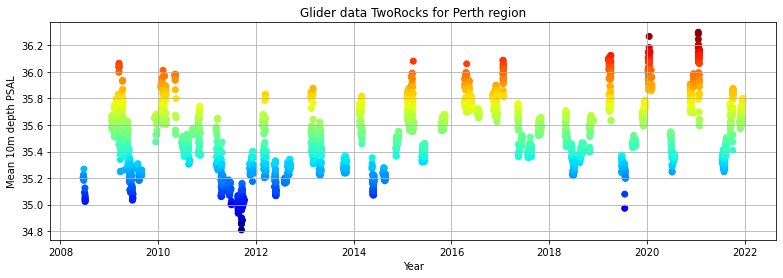

In [12]:
# Plot the quality controlled depth data
%matplotlib inline
fig, ax = plt.subplots(figsize=(13,4))
ax.scatter(alltemp['TIME'].values, alltemp[vname].values, c=alltemp[vname].values, cmap = 'jet' )
plt.grid();
ax.set_xlabel('Year')
ax.set_ylabel('Mean 10m depth %s' %vname)
plt.title('Glider data TwoRocks for Perth region');

In [14]:
climatology_mean = alltemp[vname].groupby("TIME.month").mean("TIME")

In [15]:
climatology_mean

<xarray.DataArray 'PSAL' (month: 12)>
array([35.93873065, 35.69401822, 35.62742627, 35.52519074, 35.49215858,
       35.32148414, 35.36001318, 35.36514157, 35.32376711, 35.53503142,
       35.61928156, 35.67968152])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

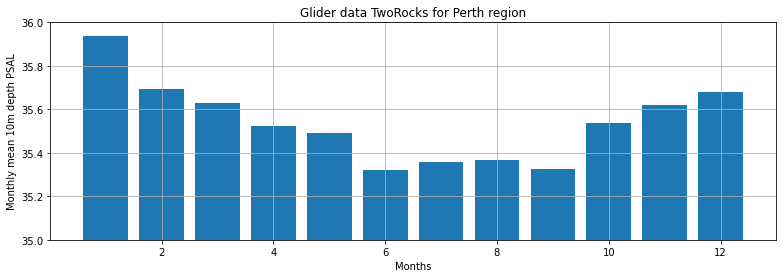

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(13,4))
ax.bar(climatology_mean['month'].values,climatology_mean.values)
ax.set_ylim(35, 36)
plt.grid(True)
ax.set_xlabel('Months')
ax.set_ylabel('Monthly mean 10m depth %s' %vname)
plt.title('Glider data TwoRocks for Perth region')
plt.show()

In [1]:
!pwd

/home/ubuntu/notebooks


In [3]:
!ls -lah  *.nc

-rw-rw-r-- 1 ubuntu ubuntu 1.2M May 17 01:29 Dennis_2022.nc
-rw-rw-r-- 1 ubuntu ubuntu 1.2M May 16 08:52 Dennis_test.nc
-rw-r--r-- 1 ubuntu ubuntu 5.3M Dec  3 02:45 merc2roms_SST__2020_01_31.nc
-rw-r--r-- 1 ubuntu ubuntu  81K Dec  3 02:45 merc_SST__2020_01_31.nc
-rw-rw-r-- 1 ubuntu ubuntu  22M May  6 05:18 michele_global.nc
-rw-rw-r-- 1 ubuntu ubuntu 2.3M May 18 02:37 michele.nc
-rw-rw-r-- 1 ubuntu ubuntu  87K May 16 22:56 Paul_glider.nc
-rw-rw-r-- 1 ubuntu ubuntu  88K May 20 01:24 Paul_glider_PSAL.nc
-rw-rw-r-- 1 ubuntu ubuntu  88K May 19 14:49 Paul_glider_PSAL_opendap.nc
-rw-rw-r-- 1 ubuntu ubuntu  88K May 20 01:18 Paul_glider_TEMP.nc
-rw-rw-r-- 1 ubuntu ubuntu  88K May 18 23:48 Paul_glider_TEMP_opendap.nc
-rw-rw-r-- 1 ubuntu ubuntu  88K May 20 01:17 Paul_glider_TEMP_s3.nc
-rw-r--r-- 1 ubuntu ubuntu 5.3M Dec  3 02:59 roms_SST__2020_01_31.nc
-rw-rw-r-- 1 ubuntu ubuntu  12M Apr 29 05:18 weights_roms_l3s.nc


In [4]:
!mkdir /home/ubuntu/public_html/Paul

In [5]:
!mv Paul_glider_PSAL.nc Paul_glider_TEMP.nc /home/ubuntu/public_html/Paul/

In [ ]:
!cp IMOS_AODN_glider_PSAL.ipynb 